In [19]:
from symc import SyncSimulation, SyncConfig, SimConfig
from symc.plotting import corner_plot
from symc.likelihoods import LIKELIHOODS

likelihood = LIKELIHOODS['single_gaussian']

In [2]:
from rich.pretty import pprint
import numpy as np
import matplotlib.pyplot as plt

### Famous egg box function 🥚 by default

In [21]:
sim = SyncSimulation()
pprint(sim)

2 dimensional egg_box simulator.

In [22]:
x = sim.sample(10000)
y = sim(x)

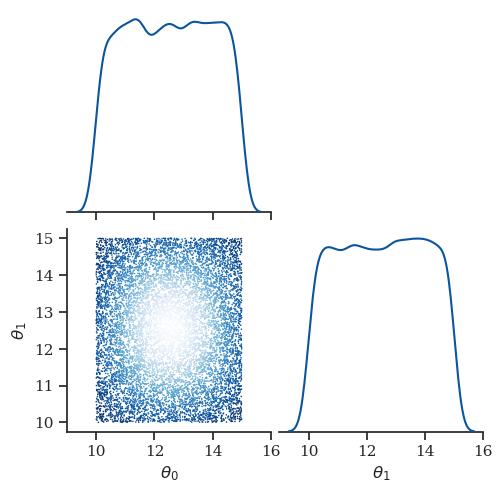

In [23]:
g = corner_plot(x,y)

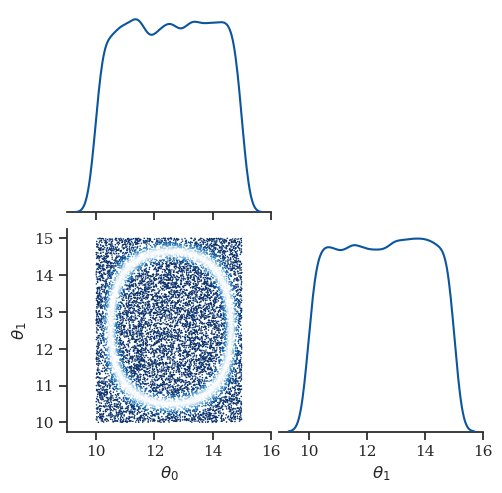

In [25]:
g = corner_plot(x, likelihood(y,goal=100), cmap='Blues_r')
plt.show()

#### More eggs

In [26]:
more_eggs = SyncConfig() 
more_eggs.bounds = ((0, 10*np.pi))
more_eggs

SyncConfig(simulation='egg_box', input_dimension=2, output_dimension=1, bounds=(0, 31.41592653589793), normalised_input=False, norm_limits=(-1, 1), sim_config=None)

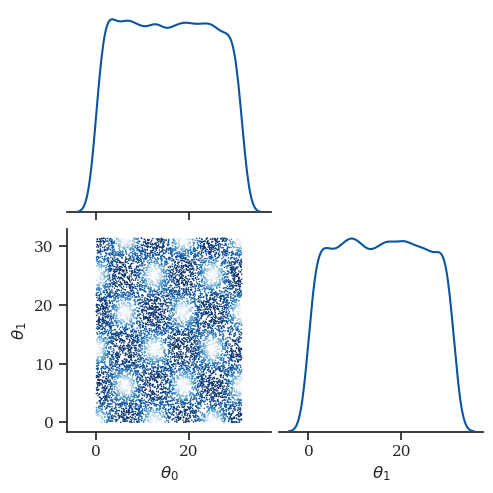

In [27]:
sim = SyncSimulation(sync_config=more_eggs)
x = sim.sample(10000)
y = sim(x)
g = corner_plot(x,y)

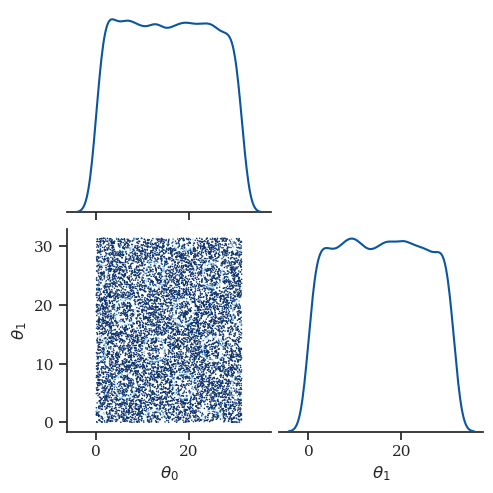

In [28]:
g = corner_plot(x, likelihood(y,goal=100), cmap='Blues_r')
plt.show()

### Rosenbrock function 🍌

In [8]:
rosenbrock = SyncConfig()
rosenbrock.simulation = 'rosenbrock2d'
rosenbrock.bounds = [[-1.5, 1.5],[0.,2.],[0.,1.]]
rosenbrock.input_dimension = 3
pprint(rosenbrock)

SyncConfig(
│   simulation='rosenbrock2d',
│   input_dimension=3,
│   output_dimension=1,
│   bounds=[[-1.5, 1.5], [0.0, 2.0], [0.0, 1.0]],
│   normalised_input=False,
│   norm_limits=(-1, 1),
│   sim_config=None
)

In [9]:
sim = SyncSimulation(sync_config=rosenbrock)

In [10]:
x = sim.sample(10000)
y = sim(x)

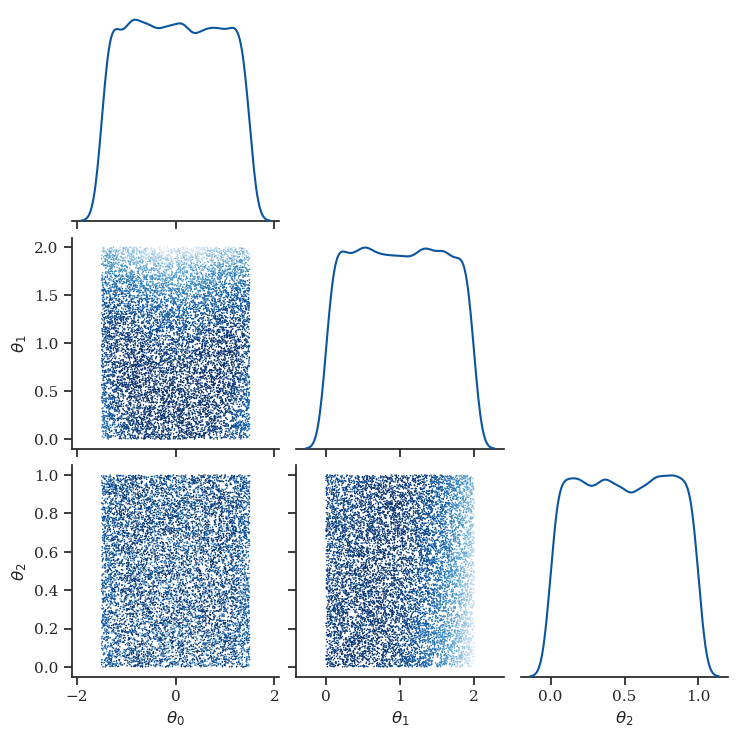

In [11]:
corner_plot(x,y)

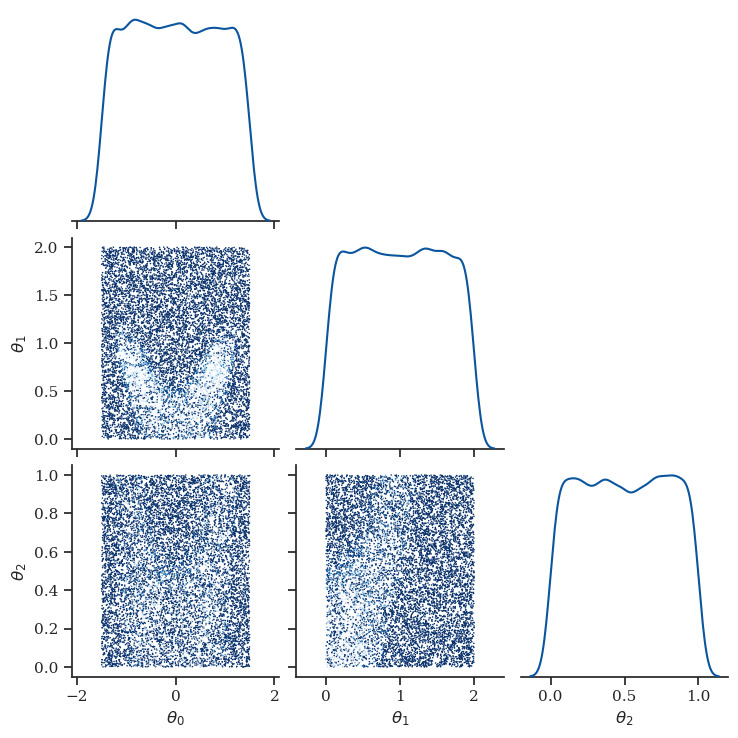

In [20]:
g = corner_plot(x, likelihood(y,goal=10), cmap='Blues_r')
plt.show()